In [3]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
data_df = pd.read_csv('../../../data/processed/fully_integrated_data.csv')
data_df.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

In [5]:
data_df = data_df[data_df["driverRaceResultStatus"] == "Finished"]

# Merge dataset with itself to compare teams within the same race
data_df_compare = data_df.merge(data_df, on=["raceId"], suffixes=("", "_opponent"))

# Remove comparisons where the team is the same
data_df_compare = data_df_compare[data_df_compare["constructorName"] != data_df_compare["constructorName_opponent"]]

# Determine win/loss based on finishing position
data_df_compare["win"] = data_df_compare["driverFinalRank"] < data_df_compare["driverFinalRank_opponent"]
data_df_compare["loss"] = data_df_compare["driverFinalRank"] > data_df_compare["driverFinalRank_opponent"]

# Aggregate head-to-head results
team_performance = data_df_compare.groupby(["constructorName", "constructorName_opponent"]).agg(
    total_races_against=("raceId", "count"),
    wins_against=("win", "sum"),
    losses_against=("loss", "sum")
).reset_index()

# Compute win rate against opponents
team_performance["win_rate_against"] = (
    team_performance["wins_against"] / team_performance["total_races_against"]
).round(3)

# Average points per team per race
team_avg_points = data_df.groupby("constructorName").agg(
    constructor_avg_points=("constructorRacePoints", "mean")
).reset_index()

# Merge with head-to-head performance
team_performance = team_performance.merge(team_avg_points, on="constructorName", how="left")

print("Head-to-Head Team Performance:")
team_performance.head()

Head-to-Head Team Performance:


,constructorName,constructorName_opponent,total_races_against,wins_against,losses_against,win_rate_against,constructor_avg_points
0,ATS,Brabham,1,0,1,0.0,1.0
1,ATS,Ferrari,3,0,3,0.0,1.0
2,ATS,Fittipaldi,1,0,1,0.0,1.0
3,ATS,McLaren,2,0,2,0.0,1.0
4,ATS,Renault,1,0,1,0.0,1.0


In [11]:
# Aggregate win/loss rate per circuit type
circuit_performance = data_df_compare.groupby(["constructorName", "circuitName", "circuitLocation"]).agg(
    total_races=("raceId", "count"),
    circuit_wins=("win", "sum"),
    circuit_losses=("loss", "sum"),
    circuit_avg_points=("constructorRacePoints", "mean")
).reset_index()

# Compute win/loss rate per circuit
circuit_performance["circuit_win_rate"] = (circuit_performance["circuit_wins"] / circuit_performance["total_races"]).round(3)

print("Circuit-Based Team Performance:")
circuit_performance.head()

Circuit-Based Team Performance:


,constructorName,circuitName,circuitLocation,total_races,circuit_wins,circuit_losses,circuit_avg_points,circuit_win_rate
0,ATS,Autódromo Juan y Oscar Gálvez,Buenos Aires,10,0,10,0.000000,0.000
1,ATS,Watkins Glen,New York State,4,0,4,2.000000,0.000
2,Alfa Romeo,Albert Park Grand Prix Circuit,Melbourne,40,7,33,3.000000,0.175
3,Alfa Romeo,Autodromo Enzo e Dino Ferrari,Imola,46,14,32,3.782609,0.304
4,Alfa Romeo,Autodromo Internazionale del Mugello,Mugello,11,3,8,2.000000,0.273


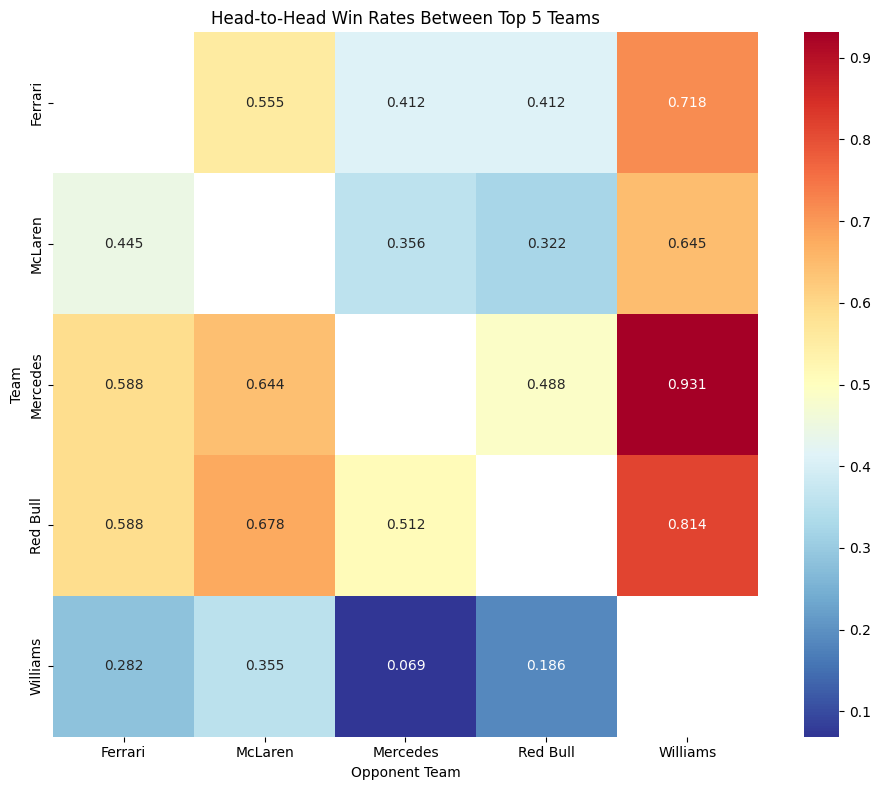

In [23]:
# Get top 5 teams by total races
top_teams = circuit_performance.groupby('constructorName')['total_races'].sum().nlargest(5).index

# Filter data for only matches between top 5 teams
top_team_performance = team_performance[
    (team_performance['constructorName'].isin(top_teams)) & 
    (team_performance['constructorName_opponent'].isin(top_teams))
]

# Create pivot table
pivot_data = top_team_performance.pivot(
    index='constructorName',
    columns='constructorName_opponent',
    values='win_rate_against'
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_data, 
            cmap='RdYlBu_r',
            center=0.5,
            annot=True,
            fmt='.3f',
            square=True)
plt.title('Head-to-Head Win Rates Between Top 5 Teams')
plt.xlabel('Opponent Team')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


C:\Users\yeshw\AppData\Local\Temp\ipykernel_5228\1767350706.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rivalry_data['cumulative_wins'] = rivalry_data.groupby('constructorName')['win'].cumsum()


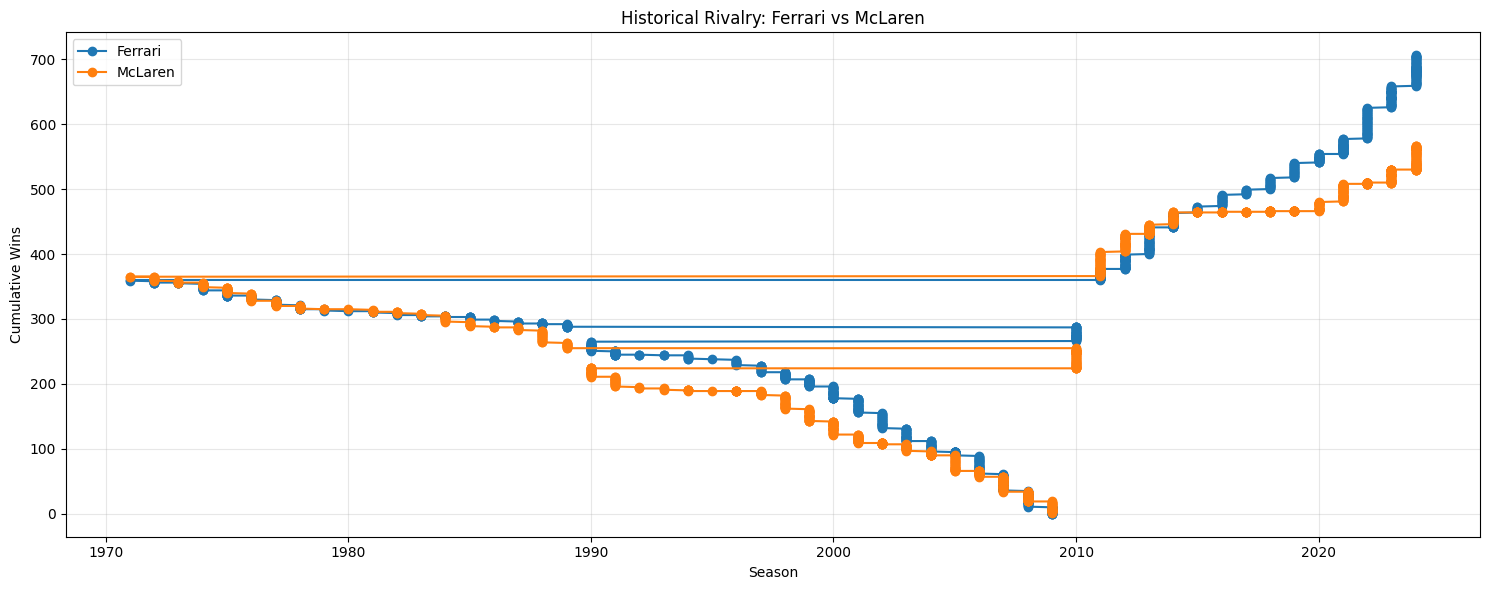

In [28]:
def plot_rivalry_timeline(data_df_compare, team1, team2):
    """
    Create timeline of specific team rivalry
    """
    # Filter for specific rivalry
    rivalry_data = data_df_compare[
        ((data_df_compare['constructorName'] == team1) & 
         (data_df_compare['constructorName_opponent'] == team2)) |
        ((data_df_compare['constructorName'] == team2) & 
         (data_df_compare['constructorName_opponent'] == team1))
    ]
    
    # Calculate cumulative win rates
    rivalry_data['cumulative_wins'] = rivalry_data.groupby('constructorName')['win'].cumsum()
    
    plt.figure(figsize=(15, 6))
    for team in [team1, team2]:
        team_data = rivalry_data[rivalry_data['constructorName'] == team]
        plt.plot(team_data['season'], 
                team_data['cumulative_wins'],
                label=team,
                marker='o')
    
    plt.title(f'Historical Rivalry: {team1} vs {team2}')
    plt.xlabel('Season')
    plt.ylabel('Cumulative Wins')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_rivalry_timeline(data_df_compare, 'Ferrari', 'McLaren')



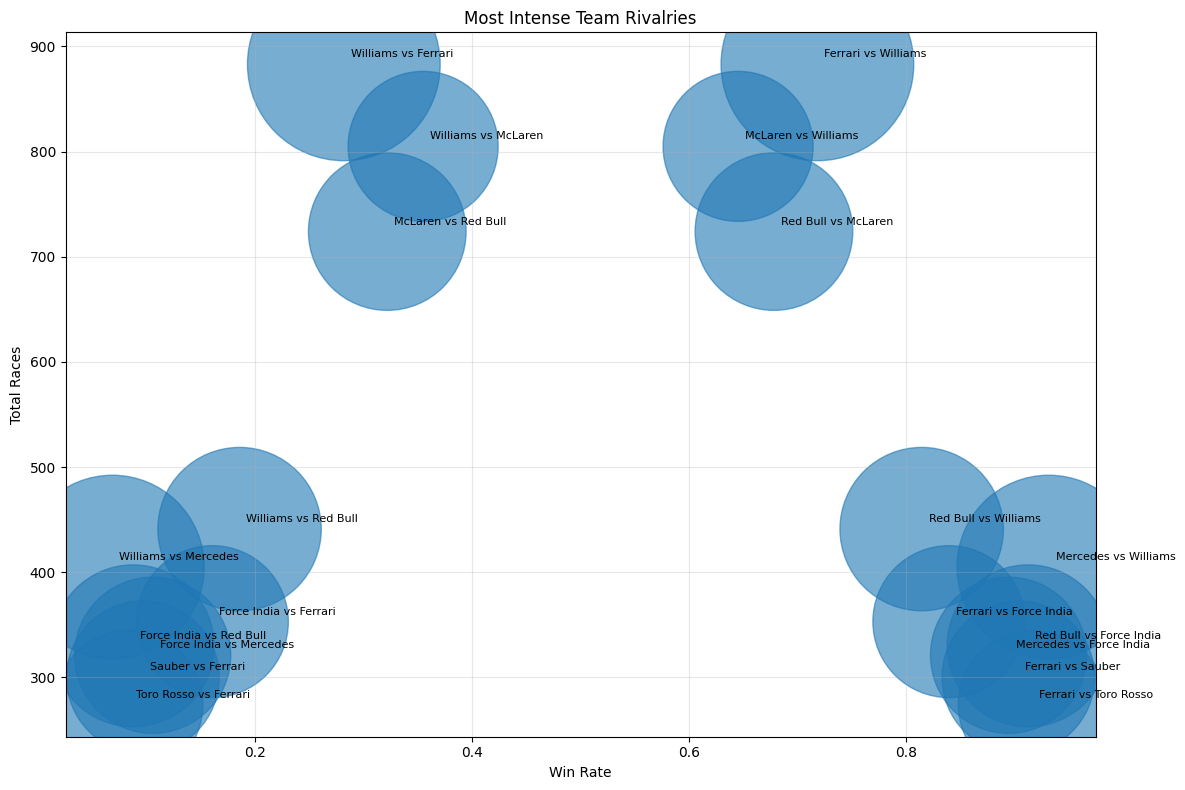

In [29]:
def plot_rivalry_intensity(team_performance):
    """
    Create bubble plot showing rivalry intensities
    """
    # Calculate rivalry intensity
    team_performance['rivalry_intensity'] = (
        team_performance['total_races_against'] * 
        abs(team_performance['win_rate_against'] - 0.5)
    )
    
    # Get top 20 most intense rivalries
    top_rivalries = team_performance.nlargest(20, 'rivalry_intensity')
    
    plt.figure(figsize=(12, 8))
    plt.scatter(top_rivalries['win_rate_against'],
                top_rivalries['total_races_against'],
                s=top_rivalries['rivalry_intensity'] * 100,
                alpha=0.6)
    
    # Add labels for each rivalry
    for idx, row in top_rivalries.iterrows():
        plt.annotate(f"{row['constructorName']} vs {row['constructorName_opponent']}",
                    (row['win_rate_against'], row['total_races_against']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8)
    
    plt.title('Most Intense Team Rivalries')
    plt.xlabel('Win Rate')
    plt.ylabel('Total Races')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_rivalry_intensity(team_performance)

##### Plots for Cicruit_performance on the teams

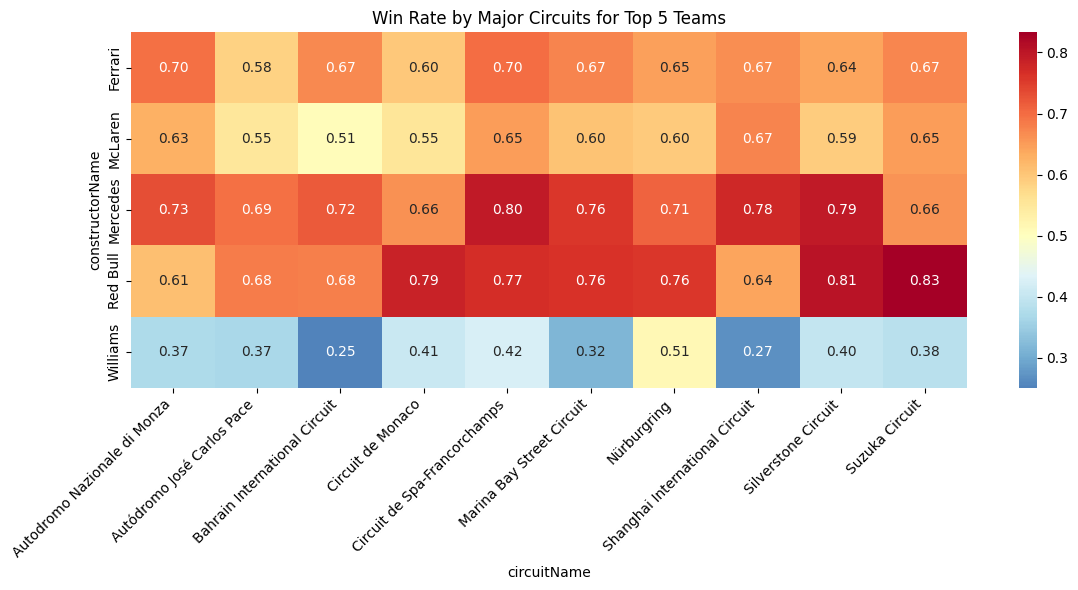

In [20]:
def plot_win_rate_heatmap(circuit_performance):
    """
    Create heatmap of win rates for top teams across major circuits
    """
    # Get top circuits by total races
    top_circuits = circuit_performance.groupby('circuitName')['total_races'].sum().nlargest(10).index
    
    # Get top teams by total races
    top_teams = circuit_performance.groupby('constructorName')['total_races'].sum().nlargest(5).index
    
    # Filter data for top teams and circuits
    filtered_data = circuit_performance[
        (circuit_performance['constructorName'].isin(top_teams)) & 
        (circuit_performance['circuitName'].isin(top_circuits))
    ]
    
    # Create pivot table
    pivot_data = pd.pivot_table(
        filtered_data,
        values='circuit_win_rate',
        index='constructorName',
        columns='circuitName',
        aggfunc='mean'
    )
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_data, 
                cmap='RdYlBu_r',
                center=0.5,
                annot=True,
                fmt='.2f')
    plt.title('Win Rate by Major Circuits for Top 5 Teams')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_win_rate_heatmap(circuit_performance)

C:\Users\yeshw\AppData\Local\Temp\ipykernel_5228\147786170.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data,


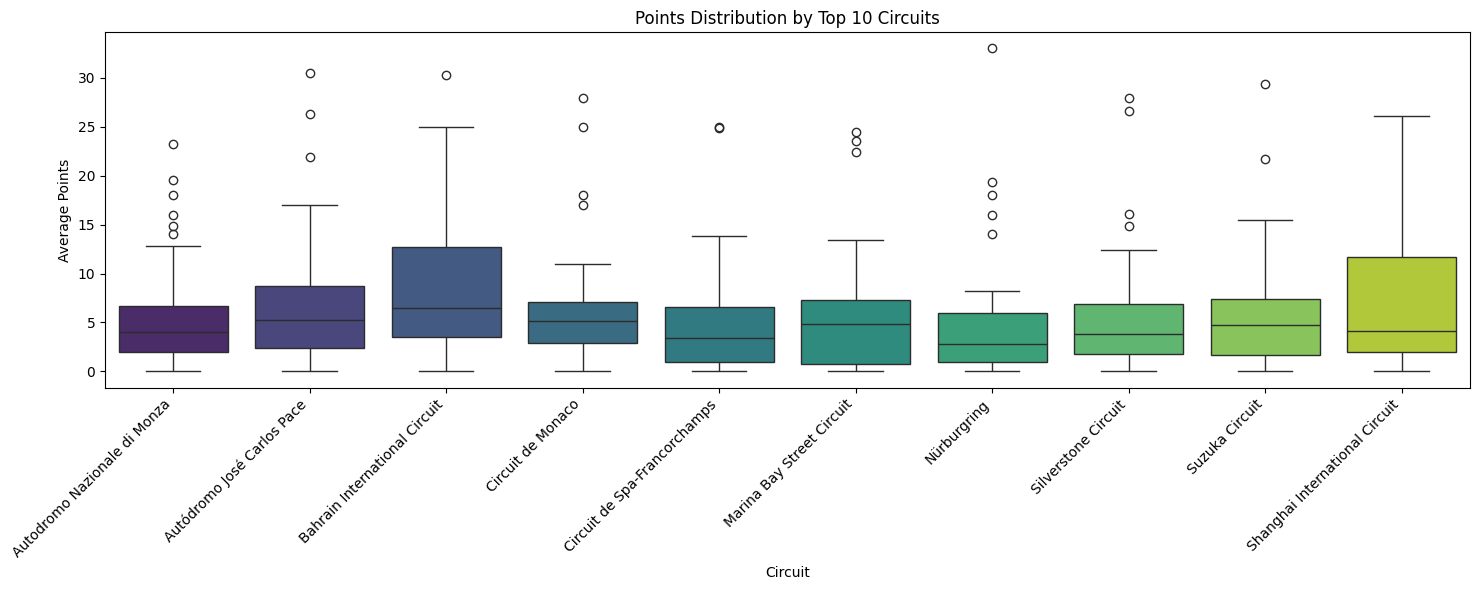

In [21]:
def plot_circuit_points_distribution(circuit_performance):
    """
    Box plot showing points distribution across top 10 circuits
    """
    # Get top 10 circuits by total races
    top_circuits = circuit_performance.groupby('circuitName')['total_races'].sum().nlargest(10).index
    
    # Filter data for top circuits
    filtered_data = circuit_performance[circuit_performance['circuitName'].isin(top_circuits)]
    
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=filtered_data,
                x='circuitName',
                y='circuit_avg_points',
                palette='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.title('Points Distribution by Top 10 Circuits')
    plt.xlabel('Circuit')
    plt.ylabel('Average Points')
    plt.tight_layout()
    plt.show()

plot_circuit_points_distribution(circuit_performance)

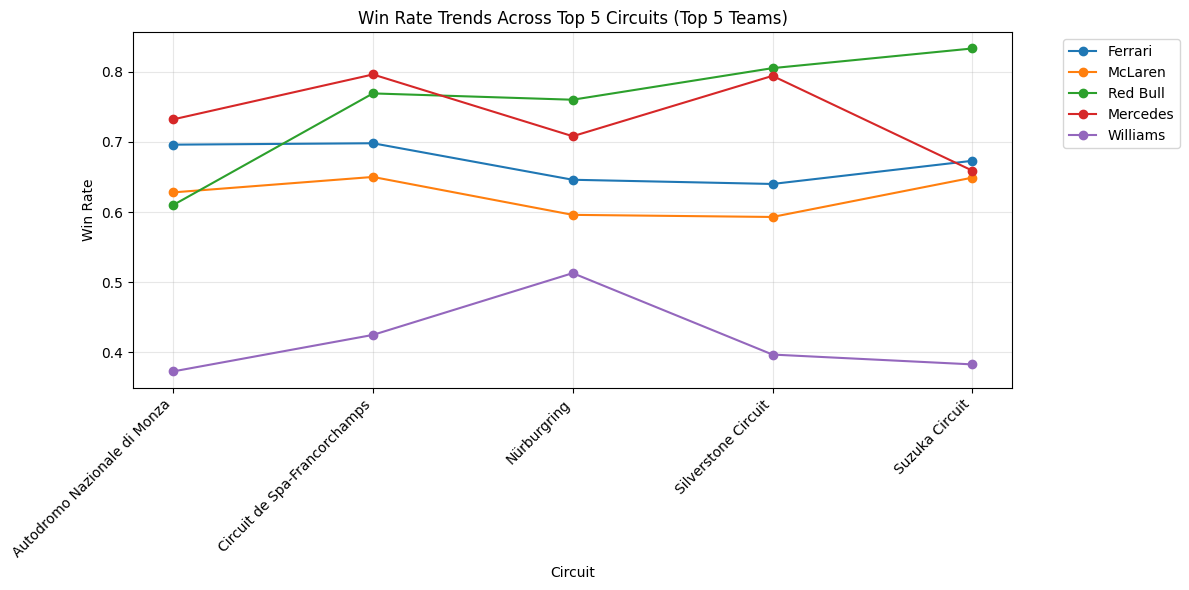

In [ ]:
def plot_team_circuit_trends(circuit_performance):
    # Get top 5 teams by total wins
    top_teams = circuit_performance.groupby('constructorName')['circuit_wins'].sum().nlargest(5).index
    
    # Get top 5 circuits by total races
    top_circuits = circuit_performance.groupby('circuitName')['total_races'].sum().nlargest(5).index
    
    # Filter data for top teams and circuits
    filtered_data = circuit_performance[
        (circuit_performance['constructorName'].isin(top_teams)) & 
        (circuit_performance['circuitName'].isin(top_circuits))
    ]
    
    plt.figure(figsize=(12, 6))
    for team in top_teams:
        team_data = filtered_data[filtered_data['constructorName'] == team]
        plt.plot(team_data['circuitName'], 
                team_data['circuit_win_rate'], 
                marker='o',
                label=team)
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Win Rate Trends Across Top 5 Circuits (Top 5 Teams)')
    plt.xlabel('Circuit')
    plt.ylabel('Win Rate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_team_circuit_trends(circuit_performance)

##### Performing Statistical test To determine That The circuit affects The head-to head performance

#### perform Two way Anova

##### Multiple Linear Regression Results